## Text Clustering and Labeling Utilizing OpenAI API


In [2]:
import os
import openai
from dotenv import load_dotenv, find_dotenv
import hdbscan
import numpy as np
import pandas as pd
import plotly.express as px
from openai import OpenAI
from umap import UMAP
from pathlib import Path
from tqdm import tqdm
import sys
import tiktoken
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [3]:
current_directory = Path.cwd()
parent_dir = current_directory.parent

In [5]:
sys.path.append(f'{parent_dir}/py_modules')
from cluster_utils import generate_cluster_text
from cluster_utils import generate_cluster_text, build_intake_text

In [16]:
# Load the environment variables from the .env file
load_dotenv(find_dotenv(), override=True)
client = OpenAI()

# Verify if the API key is set correctly
if os.getenv('OPENAI_API_KEY'):
    print("OpenAI API key is loaded successfully.")
else:
    print("Error: OpenAI API key is not found. Check your .env file.")


OpenAI API key is loaded successfully.


In [ ]:
embedding_model = "text-embedding-3-large"
embedding_encoding = "cl100k_base"
max_tokens = 8000


In [5]:
file_path = f'{parent_dir}/outputs/data/categorical'
PCS_df = pd.read_csv(f'{file_path}/Patient Characteristics Survey (Years 2013 - 2022) (categorical).csv')

sample_size = 10000
sample_PCS_df = PCS_df.sample(n=sample_size, random_state=42)


In [ ]:
sample_PCS_df = build_intake_text(sample_PCS_df)


In [8]:
encoding = tiktoken.get_encoding(embedding_encoding)

sample_PCS_df["n_tokens"] = sample_PCS_df.intake.apply(lambda x: len(encoding.encode(x)))

#### Get embeddings and save them for future reuse

In [9]:
os.makedirs('embeddings', exist_ok=True)

In [ ]:
from tenacity import retry, stop_after_attempt, wait_random_exponential

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(10))
def get_embeddings_batch(texts, model=embedding_model):
    clean = [str(t).replace("\n", " ") for t in texts]
    response = client.embeddings.create(input=clean, model=model)
    return [d.embedding for d in response.data]

batch_size = 100
all_embeddings = []
for i in tqdm(range(0, len(sample_PCS_df), batch_size), desc="Embedding batches"):
    batch = sample_PCS_df['intake'].iloc[i:i+batch_size].tolist()
    all_embeddings.extend(get_embeddings_batch(batch))

embeddings = np.vstack(all_embeddings)

file_path = f'{parent_dir}/outputs/embeddings'
os.makedirs(file_path, exist_ok=True)
np.save(f'{file_path}/embeddings.npy', embeddings)

Embedding batches: 100%|██████████| 100/100 [03:42<00:00,  2.22s/it]


#### UMAP Dimensionality Reduction

In [ ]:
embeddings = np.load(f'{parent_dir}/outputs/embeddings/embeddings.npy')
sample_PCS_df = pd.read_csv(f'{parent_dir}/outputs/embeddings/embeddings.csv')

In [ ]:
# Reduce for clustering
umap_cluster = UMAP(n_components=30, random_state=42, n_neighbors=80, min_dist=0.0, metric='cosine')
reduced = umap_cluster.fit_transform(embeddings)


#### HDBSCAN Clustering

In [ ]:
from itertools import product

results = []
for mcs, ms, method in product([75, 100, 150, 200],
                               [5, 10, 20],
                               ['eom', 'leaf']):
    hdb = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms,
                          cluster_selection_method=method,
                          gen_min_span_tree=True).fit(reduced)
    
    n_clusters = len(set(hdb.labels_)) - 1
    noise_pct = (hdb.labels_ == -1).mean()
    validity = hdb.relative_validity_
    
    results.append({'min_cluster_size': mcs, 'min_samples': ms,
                    'method': method, 'n_clusters': n_clusters,
                    'noise_pct': round(noise_pct, 3), 'dbcv': round(validity, 4)})

results_df = pd.DataFrame(results).sort_values('dbcv', ascending=False)
print(results_df.to_string(index=False))

 min_cluster_size  min_samples method  n_clusters  noise_pct   dbcv
               75            5    eom          42      0.014 0.7480
              100           20    eom          32      0.009 0.7367
               75           10    eom          42      0.017 0.7268
              150           20    eom          22      0.022 0.7265
               75           20    eom          42      0.014 0.7191
              100           10    eom          33      0.005 0.7117
              200            5    eom          19      0.030 0.6764
              200           10    eom          19      0.030 0.6731
              100            5    eom          37      0.010 0.6681
              200           20    eom          19      0.054 0.6673
              150            5    eom          25      0.022 0.6404
              150           10    eom          25      0.015 0.6395
              150            5   leaf          33      0.040 0.4392
              200           10   leaf          2

In [ ]:
best = results_df.query("noise_pct < 0.15").iloc[0]
hdb = hdbscan.HDBSCAN(min_cluster_size=int(best['min_cluster_size']),
                      min_samples=int(best['min_samples']),
                      cluster_selection_method=best['method']).fit(reduced)
sample_PCS_df["cluster"] = hdb.labels_.astype(str)


min_cluster_size       200
min_samples              5
method                 eom
n_clusters              19
noise_pct             0.03
dbcv                0.6764
Name: 18, dtype: object


In [27]:
# Use the same parameters that K-Means used to ensure visual consistency
umap_viz = UMAP(n_components=2,
                random_state=42,
                n_neighbors=30,    # lower → more local structure, less streaking
                min_dist=0.5,      # higher → more spread, reduces band compression
                metric='cosine')

# Fit on the 'reduced' data instead of raw embeddings
viz_coords = umap_viz.fit_transform(reduced)

df_umap = pd.DataFrame(viz_coords, columns=["x", "y"])
df_umap['cluster'] = sample_PCS_df['cluster'].astype(str)

np.random.seed(42)
jitter_strength = 0.3
df_umap["x"] = viz_coords[:, 0] + np.random.normal(0, jitter_strength, len(viz_coords))
df_umap["y"] = viz_coords[:, 1] + np.random.normal(0, jitter_strength, len(viz_coords))

# Plotting with a better color scale for 20 clusters
fig = px.scatter(df_umap, x="x", y="y", color="cluster", 
                 title=f"UMAP Clusters (HDBSCAN)",
                 color_discrete_sequence=px.colors.qualitative.Alphabet, # Better for 20+ colors
                 template="plotly_white")

fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.15, xanchor="center", x=0.5),
                  width=1000,
                  height=650)
fig.show()

/Users/alexanderperalta/anaconda3/envs/healthcare_project/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [11]:
print(f"Noise points: {(hdb.labels_ == -1).sum()}")
print(f"Clustered points: {(hdb.labels_ != -1).sum()}")

Noise points: 135
Clustered points: 9865


In [12]:
sample_PCS_df[sample_PCS_df["cluster"] != "-1"]["cluster"].value_counts().sort_values()

cluster
16      75
26      76
37      76
27      79
41      79
38      80
31      80
24      84
25      86
36      86
33     105
34     106
20     107
40     111
8      121
19     123
29     138
23     141
7      144
21     146
30     149
32     150
39     152
9      153
18     164
28     174
13     177
10     178
15     178
17     202
4      212
6      226
35     231
14     256
3      262
11     317
12     496
22     501
5      511
1      727
0     1148
2     1258
Name: count, dtype: int64

In [13]:
drop_cols = ['Region Served',
             'Three Digit Residence Zip Code',
             'Survey Year',
             'intake',
             'n_tokens',
             'embedding',
             'cluster_name',
             'cluster_notes']

intake_df = sample_PCS_df.drop(columns=drop_cols, errors='ignore')

In [14]:
intake_df = build_intake_text(intake_df)

In [17]:
generate_cluster_text(intake_df, client,
                      output_col="cluster_name",
                      system_message="You are an expert health economist analyzing the New York Patient Characteristics Survey.",
                      user_template="Based on the following sample of patient intake data from a cluster of {} patients, write a short descriptive title (5-10 words) that captures the defining characteristics of this patient group.\n\nDATA:\n\n{}\n\nTOPIC TITLE:",
                      noise_label=-1)

generate_cluster_text(intake_df, client,
                      output_col="cluster_notes",
                      system_message="You are an expert health economist tasked with writing clinical notes summarizing patient characteristics.",
                      user_template="Write a concise clinical summary (one paragraph) of the key characteristics and health statuses of the patients in this cluster of {} patients. Include what distinguishes this group from a general mental health population, and end with 1-2 sentences on the specific needs and recommended interventions for this population.\n\nDATA:\n\n{}\n\nCLINICAL NOTES:",
                      noise_label=-1)

Generating cluster_notes:  65%|██████▌   | 28/43 [04:40<02:30, 10.02s/it]


KeyboardInterrupt: 

In [ ]:
clusters = sorted(list(intake_df['cluster'].unique()))

for c in clusters:
    with pd.option_context("display.max_colwidth", None):
        cluster_rows = intake_df.query(f"cluster == '{c}'")
        if not cluster_rows.empty:
            print(f"Topic Title for Cluster {c}: {cluster_rows.cluster_name.values[0]}")
            print(f"Clinical Notes: {cluster_rows.cluster_notes.values[0]}")
            print(f"Size: {len(cluster_rows)} patients")
        else:
            print(f"No data found for cluster {c}")

Topic Title for Cluster -1: Pending
Clinical Notes: Pending
Size: 727 patients
Topic Title for Cluster 0: "Unemployed Adults with Serious Mental Illness"
Clinical Notes: This clinical summary encapsulates a diverse cohort of 1,148 patients primarily consisting of adult males (with some females and children) from various living situations, predominantly residing alone or cohabitating. Most patients are White, with a significant representation of individuals identifying as Hispanic/Latino, particularly among adults. A notable feature of this group is the high prevalence of serious mental illnesses, including substance-related disorders, with many patients also facing comorbid health conditions such as hypertension, diabetes, and mobility impairments. Compared to a general mental health population, this cluster is distinguished by a higher unemployment rate, a significant portion being out of the labor force and actively seeking work, alongside substantial engagement with public assistanc

In [ ]:
hdbscan_results = intake_df.copy()

#### K-Means Clustering

In [ ]:
embeddings = np.load(f'{parent_dir}/outputs/embeddings/embeddings.npy')

sample_PCS_df = pd.read_csv(f'{parent_dir}/outputs/embeddings/embeddings.csv')

In [ ]:
# Reduce for clustering
umap_cluster = UMAP(n_components=30, random_state=42, n_neighbors=80, min_dist=0.0, metric='cosine')
reduced = umap_cluster.fit_transform(embeddings)


/Users/alexanderperalta/anaconda3/envs/healthcare_project/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
#sample_PCS_df['embedding'] = sample_PCS_df.embedding.apply(lambda x: np.array(json.loads(x.replace('\0', '')))) 
sample_PCS_df['embedding'] = sample_PCS_df.embedding.apply(lambda x: np.array(json.loads(x))) 

def calculate_cluster_metrics(data_matrix, min_clusters=3, max_clusters=40):
    results = []
    for k in tqdm(range(min_clusters, max_clusters + 1)):
        km_model = KMeans(n_clusters=k, init='k-means++', random_state=42)
        y = km_model.fit_predict(data_matrix)
        results.append({'k': k,
                        'score': silhouette_score(data_matrix, y),
                        'inertia': km_model.inertia_})
    
    return pd.DataFrame(results)

def find_optimal_cluster(cluster_results):
    return cluster_results.loc[cluster_results['score'].idxmax(), 'k']

cluster_results_km = calculate_cluster_metrics(reduced)
num_cluster = find_optimal_cluster(cluster_results_km)

print("Optimal number of clusters:", num_cluster)
print(cluster_results_km.loc[cluster_results_km['k'] == num_cluster])

  0%|          | 0/38 [00:00<?, ?it/s]

Optimal number of clusters: 20
     k     score      inertia
17  20  0.736166  9764.466797


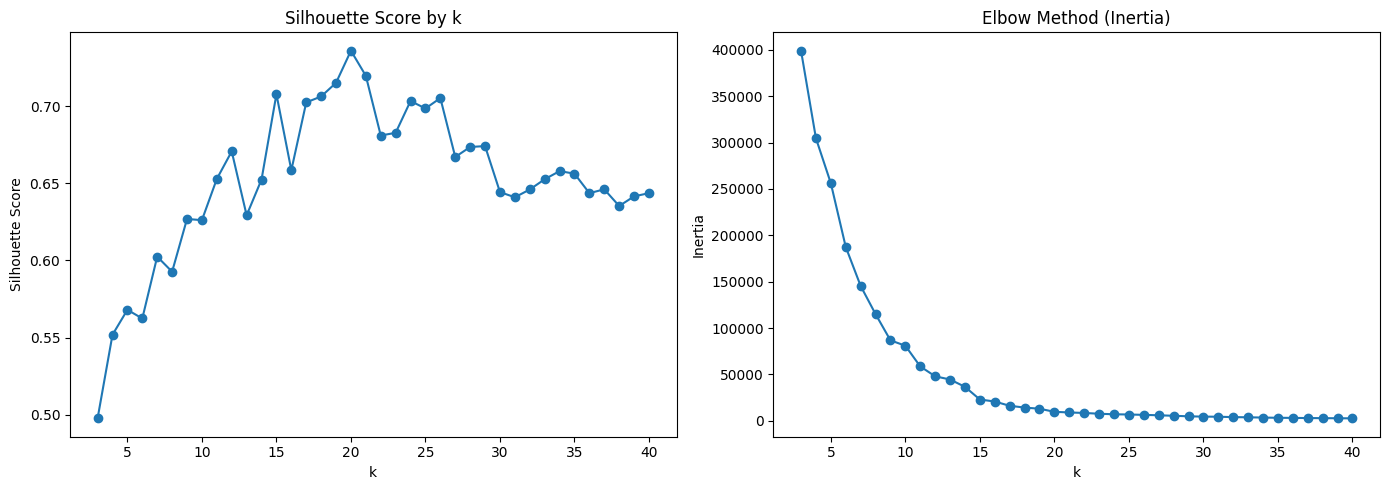

In [ ]:
# Plot both side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(cluster_results_km['k'], cluster_results_km['score'], marker='o')
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score by k')

ax2.plot(cluster_results_km['k'], cluster_results_km['inertia'], marker='o')
ax2.set_xlabel('k')
ax2.set_ylabel('Inertia')
ax2.set_title('Elbow Method (Inertia)')

plt.tight_layout()
plt.show()

In [ ]:
# final k-mean clustering
km_model = KMeans(n_clusters = num_cluster, init ='k-means++', random_state = 42)
sample_PCS_df['cluster'] = km_model.fit_predict(reduced)


In [ ]:
# Use the same parameters that K-Means used to ensure visual consistency
umap_viz = UMAP(n_components=2,
                random_state=42,
                n_neighbors=30,    # lower → more local structure, less streaking
                min_dist=0.5,      # higher → more spread, reduces band compression
                metric='cosine')

# Fit on the 'reduced' data instead of raw embeddings
viz_coords = umap_viz.fit_transform(reduced)

df_umap = pd.DataFrame(viz_coords, columns=["x", "y"])
df_umap['cluster'] = sample_PCS_df['cluster'].astype(str)

np.random.seed(42)
jitter_strength = 0.3
df_umap["x"] = viz_coords[:, 0] + np.random.normal(0, jitter_strength, len(viz_coords))
df_umap["y"] = viz_coords[:, 1] + np.random.normal(0, jitter_strength, len(viz_coords))

# Plotting with a better color scale for 20 clusters
fig = px.scatter(df_umap, x="x", y="y", color="cluster", 
                 title=f"UMAP Clusters (K-Means)",
                 color_discrete_sequence=px.colors.qualitative.Alphabet, # Better for 20+ colors
                 template="plotly_white")

fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(legend=dict(orientation="h", yanchor="top", y=-0.15, xanchor="center", x=0.5),
                  width=1000,
                  height=650)
fig.show()

/Users/alexanderperalta/anaconda3/envs/healthcare_project/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
# Check for duplicate rows in the embedding column
num_duplicates = sample_PCS_df.duplicated(subset=['intake']).sum() 
print(f"Number of duplicate text entries: {num_duplicates}")

Number of duplicate text entries: 15


In [ ]:
sample_PCS_df["cluster"].value_counts().sort_values()

cluster
13     153
18     202
11     226
14     235
8      246
12     253
10     262
16     433
19     453
0      461
2      495
15     496
17     501
9      506
4      506
7      663
3      727
5      776
1     1148
6     1258
Name: count, dtype: int64

In [ ]:
drop_cols = ['Region Served',
             'Three Digit Residence Zip Code',
             'Survey Year',
             'intake',
             'n_tokens',
             'embedding']

intake_df = sample_PCS_df.drop(columns=drop_cols)

In [ ]:
intake_df = build_intake_text(intake_df)

In [ ]:
generate_cluster_text(intake_df, client,
                      output_col="cluster_name",
                      system_message="You are an expert health economist analyzing the New York Patient Characteristics Survey.",
                      user_template="Based on the following sample of patient intake data from a cluster of {} patients, write a short descriptive title (5-10 words) that captures the defining characteristics of this patient group.\n\nDATA:\n\n{}\n\nTOPIC TITLE:",
                      noise_label=None)

generate_cluster_text(intake_df, client,
                      output_col="cluster_notes",
                      system_message="You are an expert health economist tasked with writing clinical notes summarizing patient characteristics.",
                      user_template="Write a concise clinical summary (one paragraph) of the key characteristics and health statuses of the patients in this cluster of {} patients. Include what distinguishes this group from a general mental health population, and end with 1-2 sentences on the specific needs and recommended interventions for this population.\n\nDATA:\n\n{}\n\nCLINICAL NOTES:",
                      noise_label=None)

Generating cluster_name:   0%|          | 0/20 [00:00<?, ?it/s]

Generating cluster_notes:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
clusters = sorted(list(intake_df['cluster'].unique()))

for c in clusters:
    with pd.option_context("display.max_colwidth", None):
        cluster_rows = intake_df.query(f"cluster == {c}")
        if not cluster_rows.empty:
            print(f"Topic Title for Cluster {c}: {cluster_rows.cluster_name.values[0]}")
            print(f"Clinical Notes: {cluster_rows.cluster_notes.values[0]}")
            print(f"Size: {len(cluster_rows)} patients")
        else:
            print(f"No data found for cluster {c}")

Topic Title for Cluster 0: "Predominantly Female Children with Mental Health Needs"
Clinical Notes: The patient cluster consists of 461 individuals, predominantly female, with a significant proportion identifying as Hispanic/Latino, and a notable representation of children and adolescents. The majority are living in private residences with cohabiting arrangements, largely unemployed and not seeking work, and possessing educational backgrounds ranging from pre-K through some college. Mental health issues are prevalent, with a considerable number diagnosed with serious mental illness, while chronic physical health conditions are largely absent, distinguishing this group from the general mental health population, which often includes a higher incidence of comorbid chronic physical conditions. Specific needs for this population include enhanced access to mental health resources and targeted interventions, such as counseling and educational support, particularly for those with serious menta